<a name="abstract"></a>
### Abstract

This notebook is a demonstration on how to do time-series prediction with ARIMA model. It is inspired by the blog from [machinelearningmastery.com](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).


In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

#### Dataset

The [time-series dataset](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line) is sales of shampoo over a three year peroid.

In [10]:
!ls *.csv
!head shampoo-sales.csv

shampoo-sales.csv
"Month","Sales"
"1-01",266.0
"1-02",145.9
"1-03",183.1
"1-04",119.3
"1-05",180.3
"1-06",168.5
"1-07",231.8
"1-08",224.5
"1-09",192.8


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


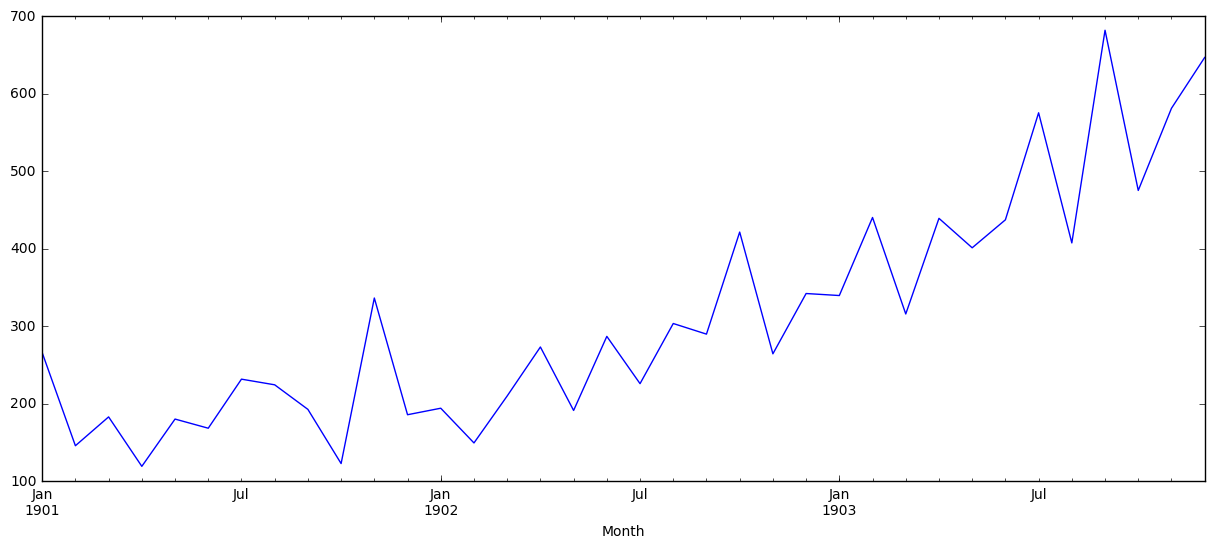

In [15]:
def parser(x):
    # add the year prefix 1900.
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo-sales.csv',
                     header=0, parse_dates=[0], index_col=0,
                     squeeze=True, date_parser=parser)

print(series.head())

_ = series.plot()

From the above graph, we could see an overall *trend* in the sales. Therefore, it is necessary to detrend the dataset in order to fit the ARIMA model.

##### Dickey-Fuller Test

Test if the dataset is stationary. And then make the input more stationary by differencing and logarithmic.

In [102]:
import statsmodels.tsa.stattools as ts

def stationary_test(series):
    # augumented Dickey-Fuller test.
    stationary_test = ts.adfuller(series.values)

    print('test-statistic: %f, p-value: %f' % (stationary_test[0], stationary_test[1]))

    # if the test-statistics is larger than any critical values, 
    #  then we cannot reject the null-hypothesis, i.e. the data is NOT stationary.
    print(stationary_test)

stationary_test(series)

test-statistic: 3.060142, p-value: 1.000000
(3.0601420836411819, 1.0, 10, 25, {'10%': -2.6328003999999998, '1%': -3.7238633119999998, '5%': -2.98648896}, 278.9972644263031)


test-statistic: 1.798463, p-value: 0.998346
(1.7984632993830769, 0.99834596437190648, 10, 25, {'10%': -2.6328003999999998, '1%': -3.7238633119999998, '5%': -2.98648896}, -20.938048906258587)


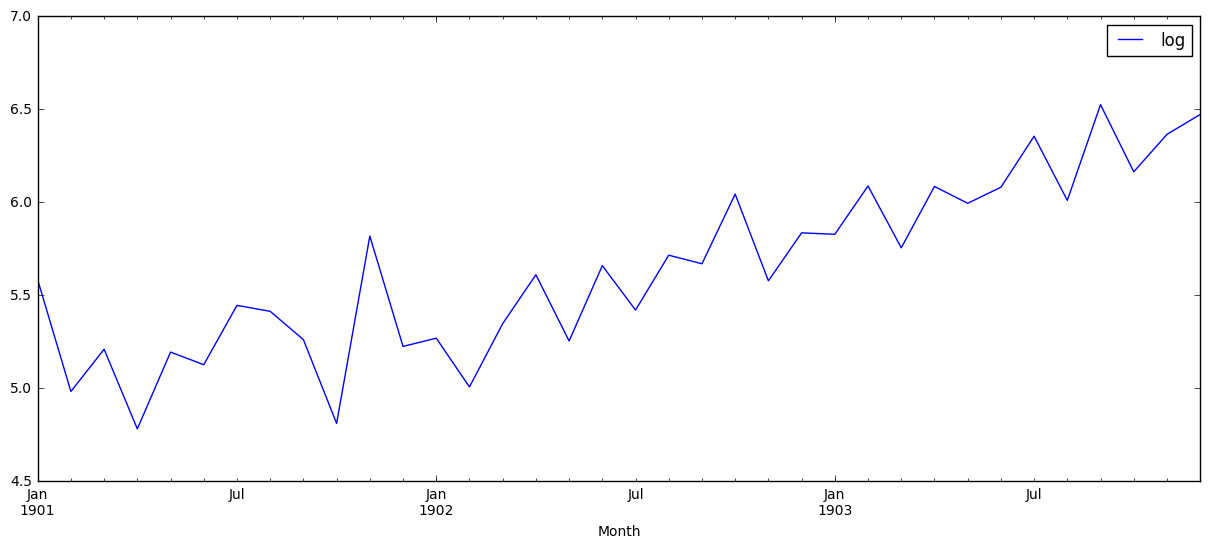

In [114]:
log = np.log(series)
log.name = "log"

stationary_test(log)

# the data should become more stationary after logarithmic 
_ = log.plot(legend=True)

test-statistic: -7.249074, p-value: 0.000000
(-7.2490740555538533, 1.7998574141687161e-10, 1, 33, {'10%': -2.6159676124885216, '1%': -3.6461350877925254, '5%': -2.954126991123355}, 275.32503579406307)


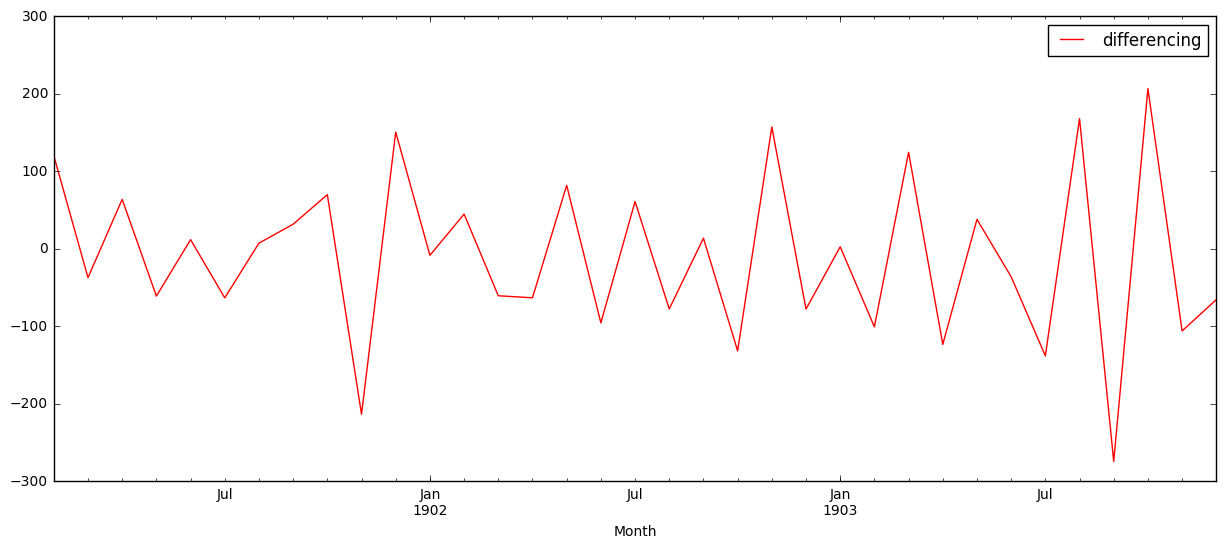

In [113]:
# differencing the input to do the detrending.
diff = (series.shift(1) - series).dropna()
diff.name = "differencing"

stationary_test(diff)

# the input becames stationary, after the differencing.
_ = diff.plot(legend=True, color='red')

test-statistic: -2.168202, p-value: 0.217988
(-2.1682021458141429, 0.21798793825603424, 10, 24, {'10%': -2.6357467361111109, '1%': -3.7377092158564813, '5%': -2.9922162731481485}, -19.775764398524217)


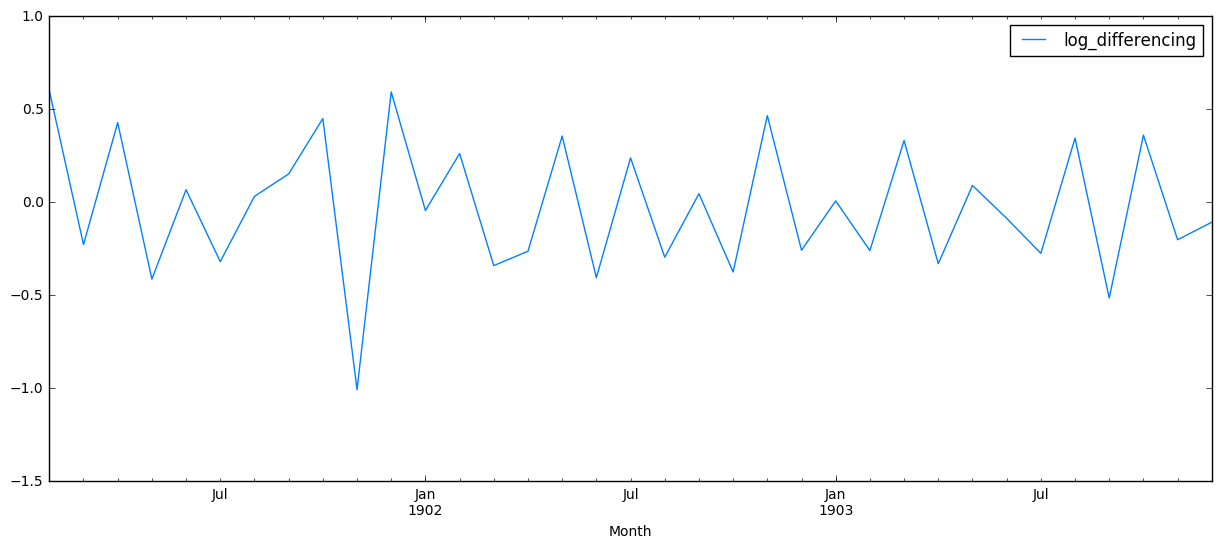

In [112]:
logdiff = (log.shift(1) - log).dropna()
logdiff.name = "log_differencing"
stationary_test(logdiff)

_ = logdiff.plot(legend=True, color=(0, 0.5, 1))

#### ARIMA (ACF/PACF)

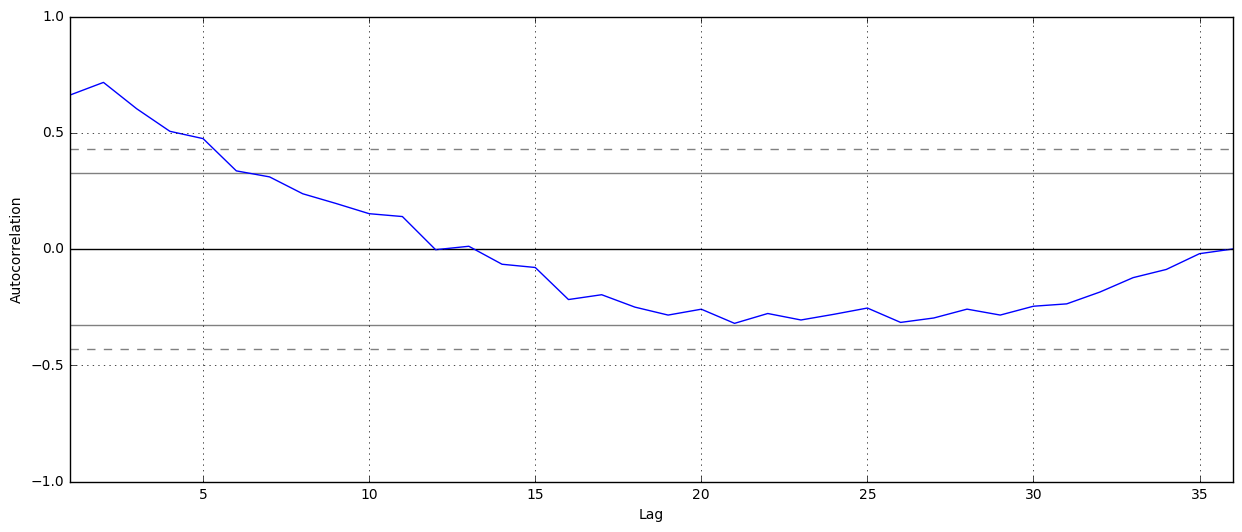

In [13]:
from pandas.tools.plotting import autocorrelation_plot

_ = autocorrelation_plot(series)

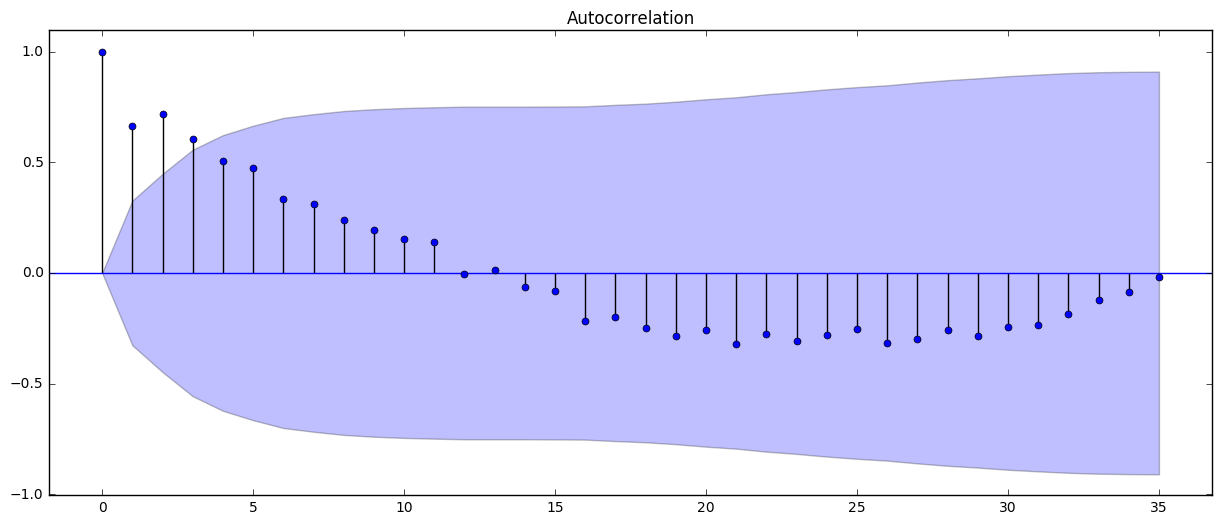

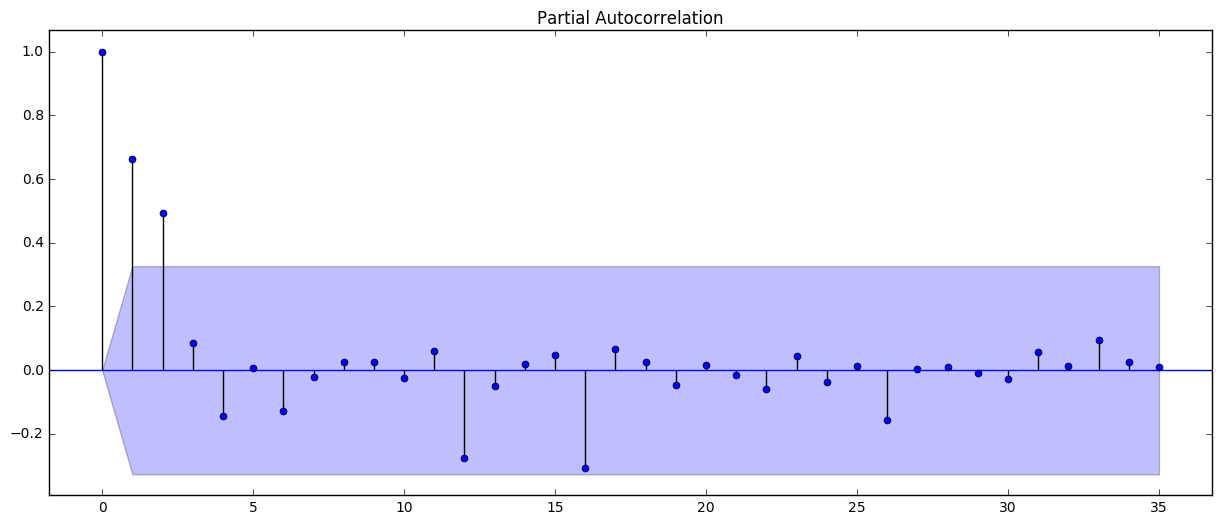

In [23]:
from statsmodels.graphics import utils, tsaplots
from statsmodels.tsa.stattools import acf, pacf

_ = tsaplots.plot_acf(series)
_ = tsaplots.plot_pacf(series)

One can get some hints on the orders (parameter, `p`, `d`, `q`) of ARIMA from the autocorrelation and partial autocorrelation plots.

In [26]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 10 Apr 2017   AIC                            406.340
Time:                        11:43:30   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003         4.908    19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000        -1.466    -0.750
ar.L2.D.Sales    -0.6203      0.282     

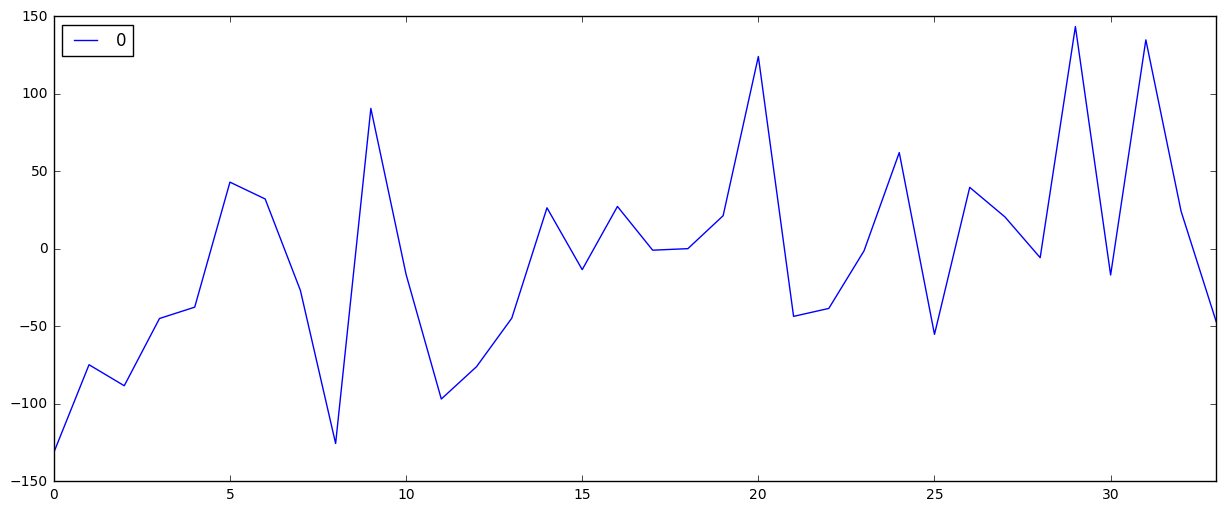

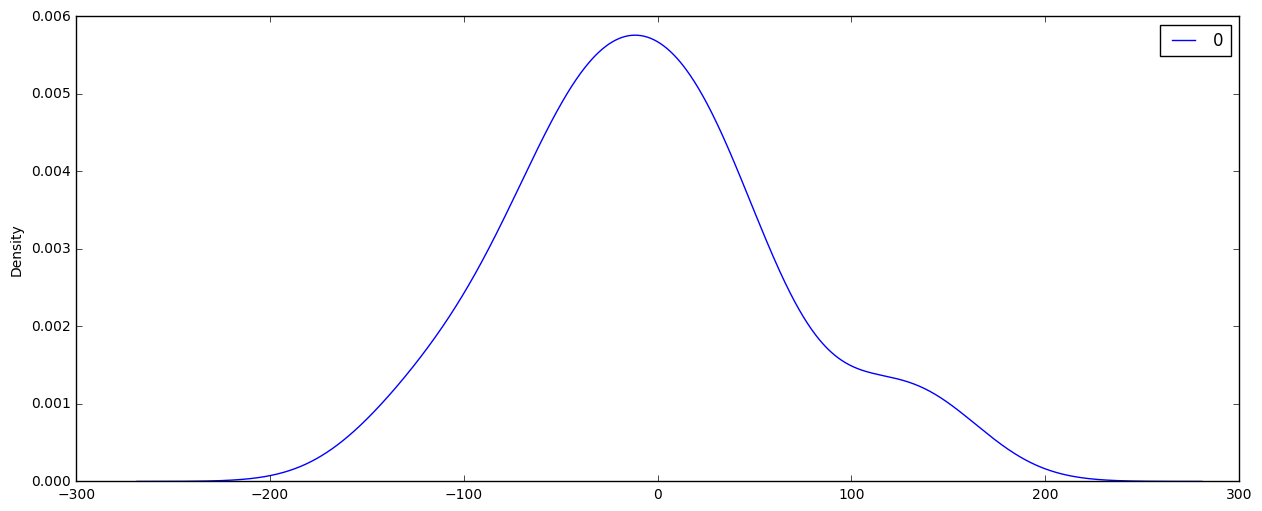

In [62]:
residuals = pd.DataFrame(model_fit.resid)
_ = residuals.plot()

_ = residuals.plot(kind='kde')

<div style="text-align:right">  <a href="#abstract">top</a> </div>


#### Rolling Forecast 

Split the data into training and test datasets, use the data from the training dataset to predict the first value in the test data set, then update the training set for the next value in the test data.

In [79]:
# Split the dataset
split = int(len(series) * 0.66)
train, test = series[0:split], series[split:]

history = [x for x in train.values]
arima_prediction = list()

for t in range(len(test)):
    # train and predict with the existing historical data
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    # add the new prediction
    arima_prediction.append(yhat)
    # prepare for the next round
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))

predicted=351.651834, expected=342.300000
predicted=309.590769, expected=339.700000
predicted=388.641587, expected=440.400000
predicted=348.777980, expected=315.900000
predicted=383.602079, expected=439.300000
predicted=360.992077, expected=401.300000
predicted=449.342095, expected=437.400000
predicted=395.449291, expected=575.500000
predicted=434.864999, expected=407.600000
predicted=512.302082, expected=682.000000
predicted=428.597164, expected=475.300000
predicted=625.993525, expected=581.300000
predicted=543.538929, expected=646.900000


#### Prediction Evaluation

Here we create a simple baseline algorithm called persistence model, *i.e.* use the previous value to predict the current value.

In [68]:
def model_persistence(series, split):
    prediction = series.shift(1)
    return prediction[int(len(series)*split):]

baseline_model = model_persistence(series, 0.66)

baseline_model.head()

Month
1902-12-01    264.5
1903-01-01    342.3
1903-02-01    339.7
1903-03-01    440.4
1903-04-01    315.9
Name: Sales, dtype: float64

Evaluate the performance of prediction, by comparing with with the baseline algorithm.

ARIMA test MSE: 6649.593573
Baseline model test MSE: 17730.518462


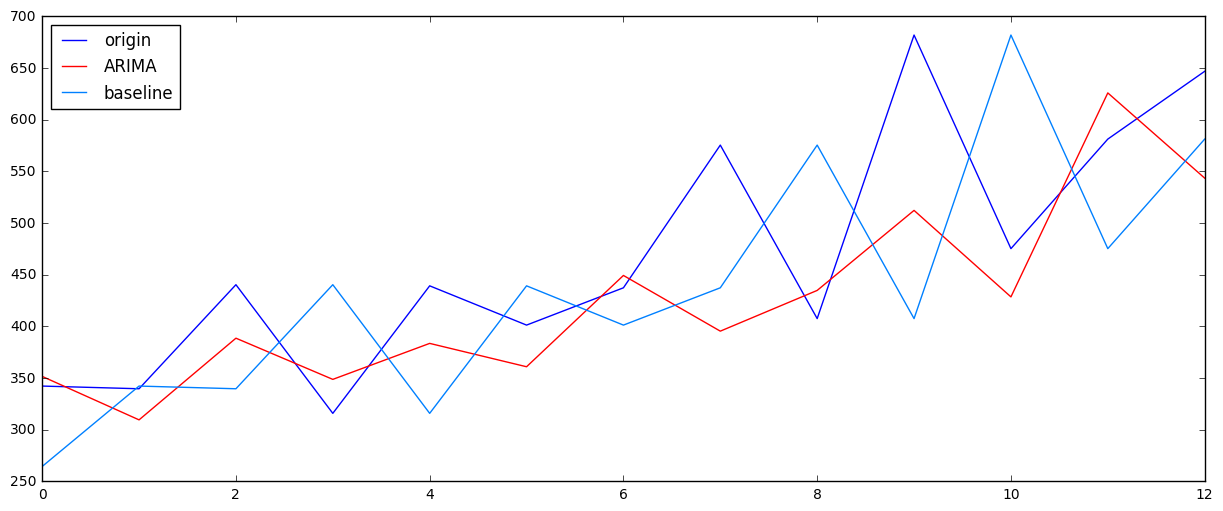

In [80]:
from sklearn.metrics import mean_squared_error

print('ARIMA test MSE: %f' % mean_squared_error(test, arima_prediction))
print('Baseline model test MSE: %f' % mean_squared_error(test, baseline_model.values))

ax = plt.subplot(111)
ax.plot(test.values, label='origin')
_ = ax.plot(arima_prediction, color='red', label='ARIMA')
_ = ax.plot(baseline_model.values, color=(0, 0.5, 1), label='baseline')

_ = plt.legend(loc='best')